# HW5 SVM

Original jupyter notebook is uploaded at [GitHub](https://github.com/zhuo34/csmath2022).

## Active set method

\begin{aligned}
\min\quad& f(\mathbf{x}) = \frac{1}{2}\mathbf{x}^TH\mathbf{x}+\mathbf{c}^T\mathbf{x} \\
\textrm{s.t.}\quad& A\mathbf{x} \geq \mathbf{b}
\end{aligned}

In [1]:
import numpy as np
import scipy
import scipy.linalg
import scipy.optimize

def ascolvec(a):
        a = np.array(a, dtype=np.float64)
        if a.ndim == 1:
            return a[:, np.newaxis]
        return a
    
def asrowvec(a):
    a = np.array(a, dtype=np.float64)
    if a.ndim == 1:
        return a[np.newaxis, :]
    return a

def solve_ActiveSet(H, c, A, b, x0=None, epsilon=1e-6, A_eq=None, b_eq=None, max_step=100, output_info=False):
    def Lagrange(H, c, A, b):
        m, n = A.shape
        AA1 = np.hstack([H, -A.T])
        AA2 = np.hstack([A, np.zeros([m, m])])
        AA = np.vstack([AA1, AA2])
        bb = np.vstack([-c, b])
        xx = scipy.linalg.solve(AA, bb)
        return xx

    m, n = A.shape
    H, c, A, b = ascolvec(H), ascolvec(c), asrowvec(A), ascolvec(b)

    has_eq = A_eq is not None
    if has_eq:
        A_eq, b_eq = asrowvec(A_eq), ascolvec(b_eq)
        m_eq = A_eq.shape[0]
        assert m_eq < n

    if x0 is None:
        if not has_eq:
            res = scipy.optimize.linprog(np.zeros(n), A_ub=-A, b_ub=np.squeeze(-b))
        else:
            res = scipy.optimize.linprog(np.zeros(n), A_ub=-A, b_ub=np.squeeze(-b), A_eq=A_eq, b_eq=b_eq)
        
        if not res.success:
            raise RuntimeError("No feasible solution.")
        x0 = res.x

    # initialize active set
    x = ascolvec(x0)
    active_set = np.where(np.abs(A @ x - b) < epsilon)[0].tolist()

    step = 0
    while step < max_step:
        m_active = len(active_set)
        _A = A[active_set]
        if has_eq:
            _A = np.vstack([_A, A_eq])
        output = Lagrange(H, H @ x + c, A[active_set], np.zeros([m_active, 1]))
        d = output[:n]
        if np.sum(np.abs(d)) < epsilon:
            # output = Lagrange(H, H @ x + c, A[active_set], b[active_set])
            lam = np.squeeze(output[n:n+m_active])
            if np.min(lam) >= 0:
                break
            idx = np.argmin(lam)
            active_set.pop(idx)
        else:
            active_map = np.zeros(m)
            active_map[active_set] = 1
            not_active_map = active_map == 0
            map2 = np.squeeze(A @ d) < 0
            alpha_map = np.logical_and(not_active_map, map2)
            in_active_idx = np.argmin(np.squeeze(A @ d))
            alpha = 1
            if np.sum(alpha_map) > 0:
                alpha = min(1, np.min((b[alpha_map] - A[alpha_map] @ x) / (A[alpha_map] @ d)))
            
            x += alpha * d

            if alpha != 1:
                active_set.append(in_active_idx)
        step += 1

    if output_info:
        return np.squeeze(x), step
    return np.squeeze(x)

H = np.array([[2, 0], [0, 2]])
c = np.array([-2, -5])
A = np.array([
    [1, -2],
    [-1, -2],
    [-1, 2],
    [1, 0],
    [0, 1]
])
b = np.array([-2, -6, -2, 0, 0])
x0 = np.array([2, 0])
A_eq = np.array([1., 1.])
b_eq = np.array([3.1])

x = solve_ActiveSet(H, c, A, b, A_eq=A_eq, b_eq=b_eq)
print(x)

[1.4 1.7]


## SVM

$$
\begin{aligned}
\min_{\mathbf{w},b}\quad&\frac{1}{2}||\mathbf{w}||^2 \\
\textrm{s.t.}\quad& y_i(\mathbf{w}^T\mathbf{x}_i+b) \geq 1,\quad i=1,2,\dots,m
\end{aligned}
$$


(200, 2) (200,)


/var/folders/96/blnd58fx0t3btcl17_wfys8m0000gn/T/ipykernel_43273/1464697119.py:25: LinAlgWarning: Ill-conditioned matrix (rcond=3.49524e-20): result may not be accurate.
  xx = scipy.linalg.solve(AA, bb)


[-0.23228059  0.16773052] -2.220446049250313e-16 [40] 8


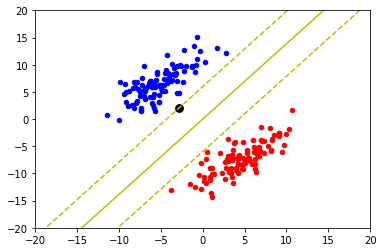

In [2]:
import matplotlib.pyplot as plt

class SVM:
    def __init__(self, kernel="linear", kernel_param=None, epsilon=1e-6, max_step=100):
        self.epsilon = epsilon
        self.kernel = kernel
        self.kernel_param = kernel_param
        if self.kernel == "linear":
            self._kernel = self._linear_kernel
        elif self.kernel == "rbf":
            self._kernel = self._rbf_kernel
            if self.kernel_param is None:
                self.kernel_param = 1
        elif self.kernel == "poly":
            self._kernel = self._poly_kernel
            if self.kernel_param is None:
                self.kernel_param = 2
        else:
            raise NotImplementedError(f"No kernel function `{self.kernel}` implemented.")
        self.max_step = max_step
        self.fitted = False

    def _linear_kernel(self, X):
        return self.X @ X.T
    
    def _rbf_kernel(self, X):
        _H = self.X @ X.T # [m1, m2]
        _diag1 = np.diag(self.X @ self.X.T)
        _diag2 = np.diag(X @ X.T)
        H = ascolvec(_diag1) - 2 * _H + asrowvec(_diag2)
        H = np.exp(-H / (2 * self.kernel_param * self.kernel_param))
        return H
    
    def _poly_kernel(self, X):
        H = self.X @ X.T # [m1, m2]
        H = H ** self.kernel_param
        return H

    def fit(self, X, y):
        self.X = X
        self.y = y
        m, n = X.shape
        H = self._kernel(X) * (ascolvec(y) @ asrowvec(y))
        c = -np.ones(m)
        A = np.eye(m)
        b = np.zeros(m)
        A_eq = np.ones(m)
        b_eq = np.zeros(1)

        self.alpha, self.step = solve_ActiveSet(H, c, A, b, x0=np.zeros(m), A_eq=A_eq, b_eq=b_eq,\
            max_step=self.max_step, output_info=True)
        self.support_vec_idx = np.where(self.alpha > self.epsilon)[0]
        self.b = np.mean((y - np.squeeze(asrowvec(self.alpha * self.y) @ self._kernel(X)))[self.support_vec_idx])
        self.fitted = True
        return self
    
    def transform(self, X):
        y = asrowvec(self.alpha * self.y) @ self._kernel(X) + self.b
        return np.squeeze(y)

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

    def get_linear_params(self):
        assert self.kernel == "linear" and self.fitted
        w = asrowvec(self.alpha * self.y) @ self.X
        return np.squeeze(w), self.b
    
    def get2dplane(self, xlim, ylim, num):
        assert self.fitted
        if isinstance(num, list) or isinstance(num, tuple):
            xnum, ynum = num[0], num[1]
        else:
            xnum, ynum = num, num
        dx = (xlim[1] - xlim[0]) / xnum
        points = []
        for i in range(xnum):
            x = np.ones(ynum) * (xlim[0] + i * dx)
            y = np.linspace(ylim[0], ylim[1], ynum)
            X = np.vstack([x, y]).T
            label = self.transform(X)
            d = label[1:] * label[:-1]
            idx = np.where(d < 0)[0]
            if len(idx):
                points.append(np.vstack([x[idx], y[idx]]).T)
        points = np.vstack(points)
        return points


np.random.seed(1234)
mu1 = np.array([-5, 7])
cov1 = np.array([
    [10, 8],
    [8, 10]
])
X1 = np.random.multivariate_normal(mu1, cov1, 100)
mu2 = np.array([5, -7])
cov2 = np.array([
    [10, 8],
    [8, 10]
])
X2 = np.random.multivariate_normal(mu2, cov2, 100)

X = np.vstack([X1, X2])
y = np.hstack([[1] * X1.shape[0], [-1] * X2.shape[0]])
print(X.shape, y.shape)

clf = SVM()
clf.fit(X, y)

w, b = clf.get_linear_params()
print(w, b, clf.support_vec_idx, clf.step)
k, b0 = -w[0] / w[1], -b / w[1]
b1 = -(b+1) / w[1]
b2 = -(b-1) / w[1]

x = np.linspace(-20, 20, 100)
y = k * x + b
y1 = k * x + b1
y2 = k * x + b2

plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.scatter(X1[:, 0], X1[:, 1], c='b', s=20)
plt.scatter(X2[:, 0], X2[:, 1], c='r', s=20)
plt.scatter(X[clf.support_vec_idx, 0], X[clf.support_vec_idx, 1], c='black', s=60)
plt.plot(x, y, c='y')
plt.plot(x, y1, '--', c='y')
plt.plot(x, y2, '--', c='y')
plt.show()

(200, 2) (200,)
70
31


/var/folders/96/blnd58fx0t3btcl17_wfys8m0000gn/T/ipykernel_43273/1464697119.py:25: LinAlgWarning: Ill-conditioned matrix (rcond=1.16325e-18): result may not be accurate.
  xx = scipy.linalg.solve(AA, bb)
/var/folders/96/blnd58fx0t3btcl17_wfys8m0000gn/T/ipykernel_43273/1464697119.py:25: LinAlgWarning: Ill-conditioned matrix (rcond=1.08302e-18): result may not be accurate.
  xx = scipy.linalg.solve(AA, bb)


100


/var/folders/96/blnd58fx0t3btcl17_wfys8m0000gn/T/ipykernel_43273/1464697119.py:25: LinAlgWarning: Ill-conditioned matrix (rcond=6.8222e-20): result may not be accurate.
  xx = scipy.linalg.solve(AA, bb)
/var/folders/96/blnd58fx0t3btcl17_wfys8m0000gn/T/ipykernel_43273/1464697119.py:25: LinAlgWarning: Ill-conditioned matrix (rcond=6.42304e-20): result may not be accurate.
  xx = scipy.linalg.solve(AA, bb)
/var/folders/96/blnd58fx0t3btcl17_wfys8m0000gn/T/ipykernel_43273/1464697119.py:25: LinAlgWarning: Ill-conditioned matrix (rcond=8.33561e-20): result may not be accurate.
  xx = scipy.linalg.solve(AA, bb)


100


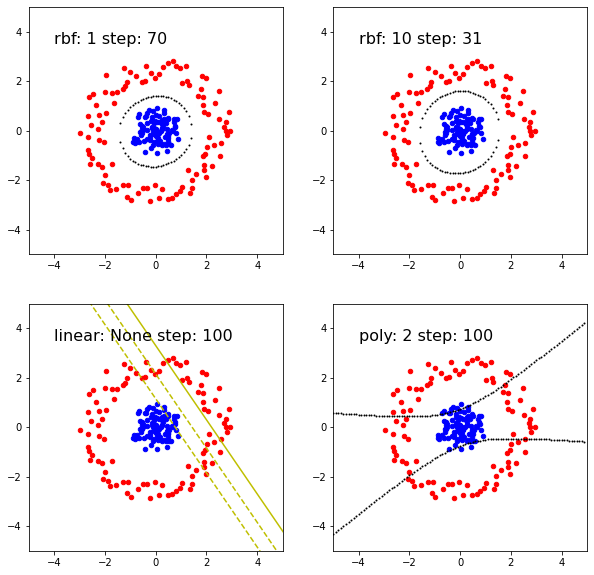

In [3]:
np.random.seed(1234)
def gen_ring_data(r1, r2, size):
    theta = np.linspace(0, 2 * np.pi, size)
    r = np.random.uniform(r1, r2, 100)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.vstack([x, y]).T

X1 = gen_ring_data(0, 1, 100)
X2 = gen_ring_data(2, 3, 100)

X = np.vstack([X1, X2])
y = np.hstack([[1] * X1.shape[0], [-1] * X2.shape[0]])
print(X.shape, y.shape)

clfs = [
    SVM(kernel="rbf", kernel_param=1, max_step=100),
    SVM(kernel="rbf", kernel_param=10, max_step=100),
    SVM(kernel="linear", max_step=100),
    SVM(kernel="poly", kernel_param=2, max_step=100),
]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, clf in enumerate(clfs):
    clf.fit(X, y)
    print(clf.step)
    if clf.kernel == "linear":
        w, b = clf.get_linear_params()
        k, b0 = -w[0] / w[1], -b / w[1]
        b1 = -(b+1) / w[1]
        b2 = -(b-1) / w[1]
        x = np.linspace(-20, 20, 100)
        y0 = k * x + b
        y1 = k * x + b1
        y2 = k * x + b2
    else:
        points = clf.get2dplane((-5, 5), (-5, 5), (100, 1000))

    ii, jj = i // 2, i % 2
    ax[ii, jj].set_xlim([-5, 5])
    ax[ii, jj].set_ylim([-5, 5])
    ax[ii, jj].scatter(X1[:, 0], X1[:, 1], c='b', s=20)
    ax[ii, jj].scatter(X2[:, 0], X2[:, 1], c='r', s=20)
    if clf.kernel == "linear":
        ax[ii, jj].plot(x, y0, c='y')
        ax[ii, jj].plot(x, y1, '--', c='y')
        ax[ii, jj].plot(x, y2, '--', c='y')
    else:
        ax[ii, jj].scatter(points[:,0], points[:,1], c='black', s=1)
    ax[ii, jj].text(-4, 3.5, f"{clf.kernel}: {clf.kernel_param} step: {clf.step}", size=16)
plt.show()